In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
#from sklearn.preprocessing import OneHotEncoder
#from pandas.plotting import scatter_matrix
#from sklearn.model_selection import cross_val_predict
#from sklearn.model_selection import cross_val_score
#import seaborn as sns
import networkx as nx
from networkx.algorithms import bipartite
%matplotlib inline

# Question 1

#### 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lectures 4 ("Read the stats carefully") and 6 ("Data visualization").

What might a naive "researcher" conclude from this superficial analysis?

In [2]:
data = pd.read_csv('lalonde.csv', index_col=0)

data.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [3]:
treated_group = data[data['treat'] == 1]
untreated_group = data[data['treat'] == 0]

In [4]:
'''
print('Treated group statistics:')
print(treated_group['re78'].describe())
print('\nMedian value for treated group:')
print(treated_group['re78'].median())

print('\n\nUntreated group statistics:')
print(untreated_group['re78'].describe())
print('\nMedian value for untreated group:')
print(untreated_group['re78'].median())
'''

treated_desc = treated_group['re78'].describe().rename("Treated")
treated_desc.set_value('median', treated_group['re78'].median())

untreated_desc = untreated_group['re78'].describe().rename("Unreated")
untreated_desc.set_value('median', untreated_group['re78'].median())

stats_df = pd.concat([treated_desc, untreated_desc], axis=1)
stats_df

,Treated,Unreated
count,185.000000,429.000000
mean,6349.143530,6984.169742
std,7867.402218,7294.161791
min,0.000000,0.000000
25%,485.229800,220.181300
50%,4232.309000,4975.505000
75%,9642.999000,11688.820000
max,60307.930000,25564.670000
median,4232.309000,4975.505000


Some observations:
- The max earning value for the treated group is way higher than the max earning for the untreated group, but the mean and median values are higher for the untreated group, which leads us to think that the treated group overall didn't get better results, even though some outliers did get a very good outcome from the trainee program. We can also observe the higher standard deviation for the treated group, which goes in the same direction.

Now lets display some plots of the distribution to visually see what it looks like.

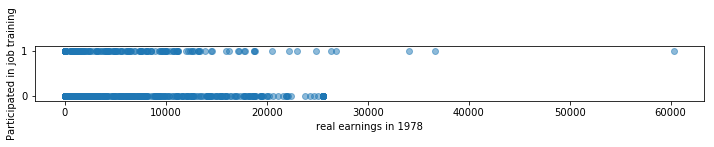

In [5]:
plt.figure(figsize=(12,1))
plt.scatter(data['re78'], data['treat'], alpha=0.5)
plt.xlabel('real earnings in 1978')
plt.ylabel('Participated in job training')

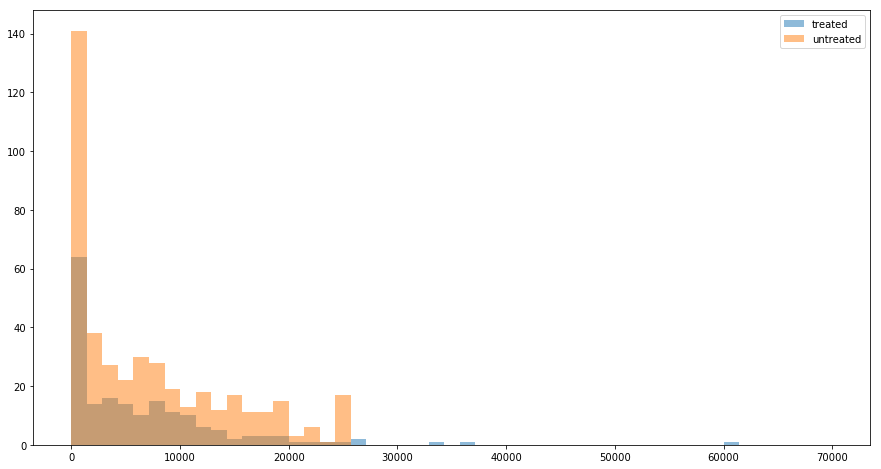

In [8]:
bins = np.linspace(0,70000, 50)

plt.figure(figsize=(15,8))
plt.hist(treated_group['re78'], bins, alpha=0.5, label='treated')
plt.hist(untreated_group['re78'], bins, alpha=0.5, label='untreated')
plt.legend(loc='upper right')
plt.show()

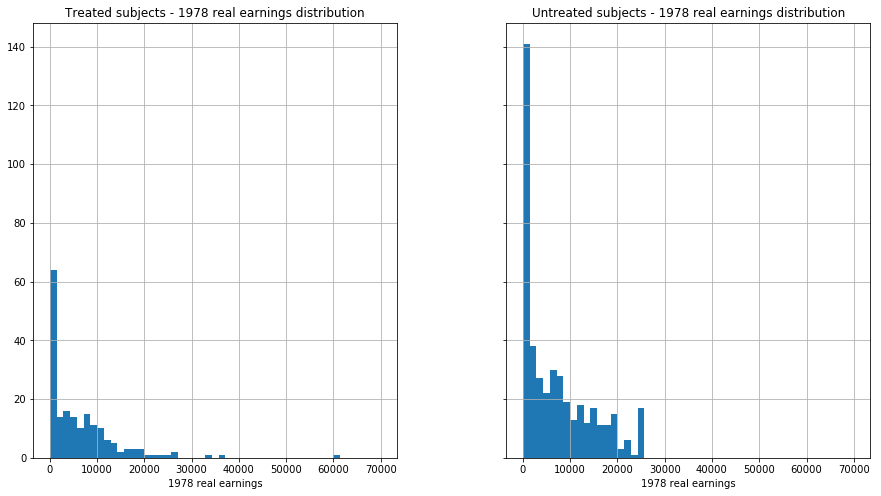

In [10]:
def set_axis(ax, treated):
    if treated:
        ax.set_title('Treated subjects - 1978 real earnings distribution')
    else:
        ax.set_title('Untreated subjects - 1978 real earnings distribution')
    ax.set_xlabel('1978 real earnings')
    return


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8), sharex=True, sharey=True)
treated_group.hist('re78', bins=bins, label='treated', ax=ax1)
untreated_group.hist('re78', bins=bins, label='untreated', ax=ax2)

set_axis(ax1, True)
set_axis(ax2, False)

#TODO create function and set all configs for axis etc. for both histograms # Complete?

# TODO our naive conclusion
#### Naive solution
The straightforward conclusion is that the treatment is not so effective as the mean of the 1972 real earnings is lower for the treated group. The fact that the maximum value for the treated group is higher for the untreated group may be discarted as outliers.

#### 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [9]:
treated_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2095.573689,1532.055314,6349.143530
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4886.620353,3219.250870,7867.402218
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,485.229800
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4232.309000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1291.468000,1817.284000,9642.999000
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


In [10]:
untreated_group.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,429.0,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000,429.000000
mean,0.0,28.030303,10.235431,0.202797,0.142191,0.512821,0.596737,5619.236506,2466.484443,6984.169742
std,0.0,10.786653,2.855238,0.402552,0.349654,0.500419,0.491126,6788.750796,3291.996183,7294.161791
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,19.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,220.181300
50%,0.0,25.000000,11.000000,0.000000,0.000000,1.000000,1.000000,2547.047000,1086.726000,4975.505000
75%,0.0,35.000000,12.000000,0.000000,0.000000,1.000000,1.000000,9277.128000,3881.419000,11688.820000
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25862.320000,18347.230000,25564.670000


Below, we compare the percent of true/false values for features concerning race ('black' and 'hispan'), marriage and degree for each group and compare in bar charts.

We also plot the distributions for the age, education and income prior to the experience to compare between the two groups.

These observations will let us determine if the two groups are equivalently distributed.

black percent for treated group: 84.32%
black percent for untreated group: 20.28%



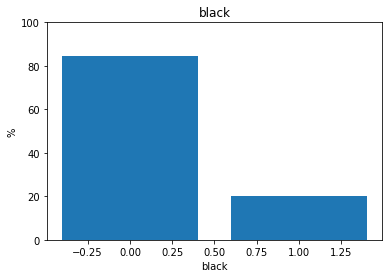

hispan percent for treated group: 5.95%
hispan percent for untreated group: 14.22%



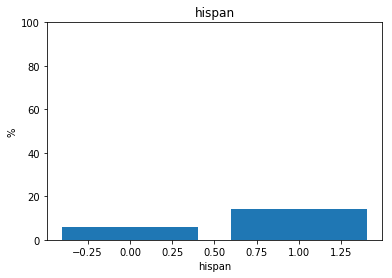

married percent for treated group: 18.92%
married percent for untreated group: 51.28%



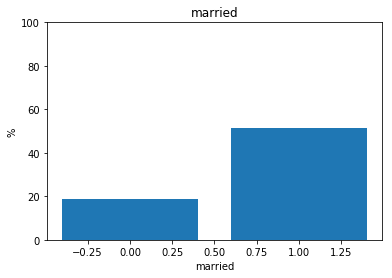

nodegree percent for treated group: 70.81%
nodegree percent for untreated group: 59.67%



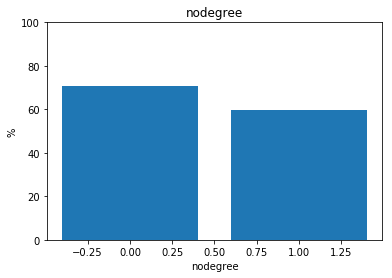

[None, None, None, None]

In [11]:
def percentage_comparison(treated_g, untreated_g, feature):
    treated_percent = 100 * np.sum(treated_g[feature]) / treated_g[feature].size
    untreated_percent = 100 * np.sum(untreated_g[feature]) / untreated_g[feature].size
    print('{} percent for treated group: {:0.2f}%'.format(feature, treated_percent))
    print('{} percent for untreated group: {:0.2f}%'.format(feature, untreated_percent))
    print()
    
    x = [u'True', u'False']
    y = [treated_percent, untreated_percent]
    fig, ax = plt.subplots() 
    plt.bar([0,1], [treated_percent, untreated_percent])
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('%')
    
    ax.set_ylim([0,100])
    
    plt.show()

features_to_compare = ['black', 'hispan', 'married', 'nodegree']
[percentage_comparison(treated_group, untreated_group, f) for f in features_to_compare]

# TODO plot values above in small bar charts with yaxis 100% to compare visually
# TODO plot in subplots side by side, nicer
# Display bar value in each bar
# TODO plot age distribution, plot years of education, display income before exp
# TODO box plots?
# TODO new column with 'race_other' (if black and hispan == 0)

- Proportionally, the number of blacks in the control group is way higher than in the treated group.
- There is also a disreptancy in the percentage of married people in each group


These observations show that the treatment assignment isn't random and there is a huge bias between the two groups in some of the covariates, such as the number of blacks. This doesn't correspond to a randomized experiment. Such disruptancies cause major differences in the groups, which alone is enough to invalidate the naive conclusions made in part 1, or at least put the above findings into question.

#### 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `sklearn` to fit the logistic regression model and apply it to each data point to obtain propensity scores:

```python
from sklearn import linear_model
logistic = linear_model.LogisticRegression()
```

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://drive.google.com/file/d/0B4jctQY-uqhzTlpBaTBJRTJFVFE/view).)

In [12]:
logistic = LogisticRegression()

confounders = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']

y = data['treat']
X = data[confounders]
logistic.fit(X, y)

prop_score = [e for (_,e) in logistic.predict_proba(X)]

data['prop_score'] = prop_score
data.head()

# TODO way to ignore re74 and re75 when zero?

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,prop_score
id,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,0.443350
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,0.144660
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,0.722355
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,0.664151
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,0.698286


Which means, for example, that the second person in the above array has a 14.5% chance of being in the treated group.


#### 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [13]:
treat_prop = data[data['treat'] == 1]['prop_score']
untreat_prop = data[data['treat'] == 0]['prop_score']

#B = nx.complete_bipartite_graph(treat_prop.size, untreat_prop.size)

B = nx.Graph()

B.add_nodes_from(treat_prop.index, bipartite=0)
B.add_nodes_from(untreat_prop.index, bipartite=1)

for l_idx, l in treat_prop.iteritems():
    for r_idx, r in untreat_prop.iteritems():
        w = abs(l - r)
        B.add_edge(l_idx, r_idx, weigth=w)

max_matching = nx.max_weight_matching(B, True)
max_matching

# TODO is this matching correct? Histogram seems fishy, too many high values??

{'NSW1': 'PSID429',
 'NSW10': 'PSID420',
 'NSW100': 'PSID330',
 'NSW101': 'PSID329',
 'NSW102': 'PSID328',
 'NSW103': 'PSID327',
 'NSW104': 'PSID326',
 'NSW105': 'PSID325',
 'NSW106': 'PSID324',
 'NSW107': 'PSID323',
 'NSW108': 'PSID322',
 'NSW109': 'PSID321',
 'NSW11': 'PSID419',
 'NSW110': 'PSID320',
 'NSW111': 'PSID319',
 'NSW112': 'PSID318',
 'NSW113': 'PSID317',
 'NSW114': 'PSID316',
 'NSW115': 'PSID315',
 'NSW116': 'PSID314',
 'NSW117': 'PSID313',
 'NSW118': 'PSID312',
 'NSW119': 'PSID311',
 'NSW12': 'PSID418',
 'NSW120': 'PSID310',
 'NSW121': 'PSID309',
 'NSW122': 'PSID308',
 'NSW123': 'PSID307',
 'NSW124': 'PSID306',
 'NSW125': 'PSID305',
 'NSW126': 'PSID304',
 'NSW127': 'PSID303',
 'NSW128': 'PSID302',
 'NSW129': 'PSID301',
 'NSW13': 'PSID417',
 'NSW130': 'PSID300',
 'NSW131': 'PSID299',
 'NSW132': 'PSID298',
 'NSW133': 'PSID297',
 'NSW134': 'PSID296',
 'NSW135': 'PSID295',
 'NSW136': 'PSID294',
 'NSW137': 'PSID293',
 'NSW138': 'PSID292',
 'NSW139': 'PSID291',
 'NSW14': 'PSID4

To check how good our matching performed, we compute the absolute difference between the two propensity scores for each pair in the matching and display a histogram of all the values.

Mean absolute propensity score: 0.38115684565223446


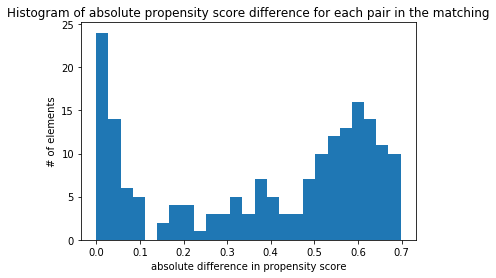

In [14]:
def get_scores(matching):
    (left, _) = bipartite.sets(B)
    return [abs(treat_prop[l] - untreat_prop[matching[l]]) for l in left]

abs_diffs = get_scores(max_matching)
print('Mean absolute propensity score: {}'.format(np.mean(abs_diffs)))

plt.hist(abs_diffs,bins=25)
plt.title('Histogram of absolute propensity score difference for each pair in the matching')
plt.xlabel('absolute difference in propensity score')
plt.ylabel('# of elements')
plt.show()

As we can see, the algorithm found many good matchings, but there is a lot of pairs that have a big difference in propensity score, due to the fact that strictly each score has to be matched with one from the other group.

In [15]:
#left side is the treated nodes, right side is untreated nodes (size)
(left, right) = bipartite.sets(B)

print('Left (treated): {}'.format(len(left)))
print('Right (untreated): {}'.format(len(right)))

Left (treated): 185
Right (untreated): 429


The left side of the bipartite graph is the smallest, thus the matching contains all nodes on the left side (185) and has matched with 185 nodes on the right side (untreated patients).

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f44ba662278>], dtype=object)

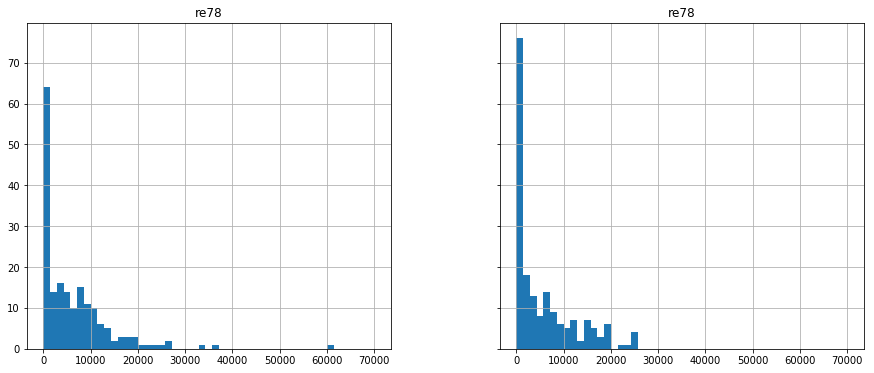

In [16]:
treated_matched_index = left #are all matched
untreated_matched_index = [max_matching[l] for l in left]
len(untreated_matched_index)

# Get only the matched proensity scores for each group
matched_treated_group = data.loc[treated_matched_index]
matched_untreated_group = data.loc[untreated_matched_index]


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,6), sharex=True, sharey=True)
matched_treated_group.hist('re78', bins=bins, label='treated', ax=ax1)
matched_untreated_group.hist('re78', bins=bins, label='untreated', ax=ax2)

# TODO can do a function to display these two histograms as we reuse code
# TODO add axis labels and title

Now, with the propensity score matching, we have an observational study and looking at the results of 1978 earnings, we could conclude that the treatment did work well for the outliers that earned a lot more than the rest. There is also less people with no income in the treated group.

black percent for treated group: 84.32%
black percent for untreated group: 27.57%



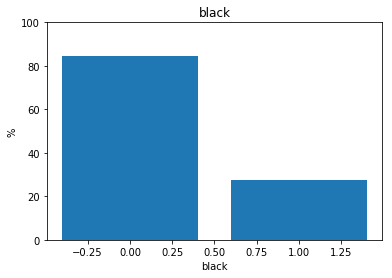

hispan percent for treated group: 5.95%
hispan percent for untreated group: 11.89%



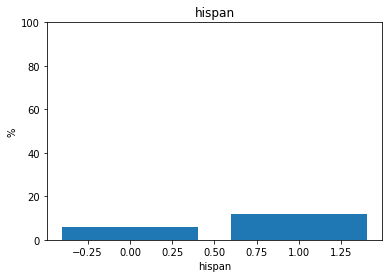

married percent for treated group: 18.92%
married percent for untreated group: 41.08%



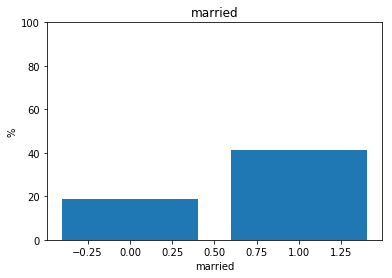

nodegree percent for treated group: 70.81%
nodegree percent for untreated group: 65.41%



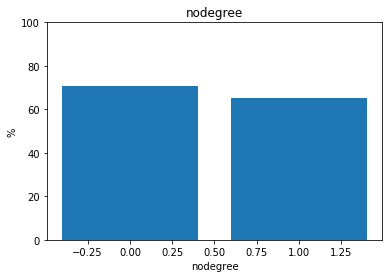

[None, None, None, None]

In [17]:
features_to_compare = ['black', 'hispan', 'married', 'nodegree']
[percentage_comparison(matched_treated_group, matched_untreated_group, f) for f in features_to_compare]

# TODO other features, like above


Even though the number of blacks, for example, is still relatively different in each group, the differences are smaller for each feature and the groups look better distributed.

#### 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [18]:
# TODO

#### 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [19]:
# TODO

## Question 2: Applied ML
We are going to build a classifier of news to directly assign them to 20 news categories. Note that the pipeline that you will build in this exercise could be of great help during your project if you plan to work with text!


#### 1
Load the 20newsgroup dataset. It is, again, a classic dataset that can directly be loaded using sklearn ([link](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)).  
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), short for term frequencyâ€“inverse document frequency, is of great help when if comes to compute textual features. Indeed, it gives more importance to terms that are more specific to the considered articles (TF) but reduces the importance of terms that are very frequent in the entire corpus (IDF). Compute TF-IDF features for every article using [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). Then, split your dataset into a training, a testing and a validation set (10% for validation and 10% for testing). Each observation should be paired with its corresponding label (the article category).

In [20]:
from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [21]:
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset="test")

#pprint(list(newsgroups_train.target_names))

# .target contains category id
# .target_name contains category name
# .filenames contains file name
# .data contains the text

# TODO display result

In [22]:
# Compute the tf-idf score for each data point
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(newsgroups_train.data)
tfidf_score = vectors.data

In this problem the label of a data point is the news category assigned to it ('target' attribute in the newsgroup dataset) and the features are tf-idf values of the text of the news article.

In [23]:
# We first split into 0.8 train, then split the remaining (0.2) into half test half validation set
X = vectors
y = newsgroups_train.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=69)

print('X Train / Test / Validation size : {} / {} / {}'.format(X_train.shape, X_test.shape, X_val.shape))
print('y Train / Test / Validation size : {} / {} / {}'.format(y_train.shape, y_test.shape, y_val.shape))


X Train / Test / Validation size : (9051, 130107) / (1132, 130107) / (1131, 130107)
y Train / Test / Validation size : (9051,) / (1132,) / (1131,)


#### 2. 
Train a random forest on your training set. Try to fine-tune the parameters of your predictor on your validation set using a simple grid search on the number of estimator "n_estimators" and the max depth of the trees "max_depth". Then, display a confusion matrix of your classification pipeline. Lastly, once you assessed your model, inspect the `feature_importances_` attribute of your random forest and discuss the obtained results.



In [24]:
clf = RandomForestClassifier(random_state=5)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=5, verbose=0, warm_start=False)

In [25]:
def get_accuracy(y_pred):
    y_diff = [y_pred == y_test]
    y_correct = np.sum(y_diff) / y_pred.size
    return y_correct

y_pred = clf.predict(X_test)
y_corr = get_accuracy(y_pred)
print('{:0.2f}%'.format(y_corr))

0.62%


In [42]:
n_estimators_range = np.logspace(1, 4, 2, dtype='int')
max_depth_range = np.logspace(1, 4, 2, dtype='int')

parameters = {'n_estimators':n_estimators_range,
              'max_depth':max_depth_range }

grid_search_clf = GridSearchCV(clf, parameters)

In [44]:
grid_search_clf.fit(X_train, y_train)

In [41]:
print(grid_search_clf.best_params_)
#print(grid_search_clf.feature_importances_)



{'max_depth': 10000, 'n_estimators': 10}


In [ ]:
# TODO test with validation set 